# Noise-free optimization with Expected Improvement

In [1]:
import numpy as np
import tensorflow as tf

np.random.seed(1793)
tf.random.set_seed(1793)

## Describe the problem

In this example, we look to find the minimum value of the two-dimensional Branin function over the hypercube $[0, 1]^2$. The Branin function is a popular toy function used in Bayesian optimization literature. Trieste provides a selection of toy functions in `trieste.objectives` package, where besides the functions we also provide their minimizers, minima and search space definitions.

Below we use a version of the Branin function scaled to the hypercube search space. For the Branin we use the predefined search space `BRANIN_SEARCH_SPACE`, but otherwise one would define the search space directly using a `Box` object (illustrated below as well). We also plot contours of the Branin over the search space.



In [2]:
from trieste.objectives import (
    scaled_branin,
    SCALED_BRANIN_MINIMUM,
    BRANIN_SEARCH_SPACE,
)
from trieste.objectives.utils import mk_observer
from util.plotting_plotly import plot_function_plotly
from trieste.space import Box

search_space = BRANIN_SEARCH_SPACE  # predefined search space, for convenience
search_space = Box([0, 0], [1, 1])  # define the search space directly

fig = plot_function_plotly(
    scaled_branin, search_space.lower, search_space.upper, grid_density=20
)
fig.update_layout(height=400, width=400)
fig.show()

## Sample the observer over the search space

Sometimes we don't have direct access to the objective function. We only have an observer that indirectly observes it. In _Trieste_, an observer can output a number of datasets. In our case, we only have one dataset, the objective. We can convert a function with `branin`'s signature to a single-output observer using `mk_observer`.

The optimization procedure will benefit from having some starting data from the objective function to base its search on. We sample a five point space-filling design from the search space and evaluate it with the observer. For continuous search spaces, Trieste supports random, Sobol and Halton initial designs.

In [3]:
import trieste

observer = trieste.objectives.utils.mk_observer(scaled_branin)

num_initial_points = 5
initial_query_points = search_space.sample_sobol(num_initial_points)
initial_data = observer(initial_query_points)

## Model the objective function

The Bayesian optimization procedure estimates the next best points to query by using a probabilistic model of the objective. We'll use Gaussian Process (GP) regression for this, as provided by GPflow. The model will need to be trained on each step as more points are evaluated, by default it uses GPflow's Scipy optimizer.

The GPflow models cannot be used directly in our Bayesian optimization routines, only through a valid model wrapper. Trieste has wrappers that support several popular models. For instance, `GPR` and `SGPR` models from GPflow have to be used with `GaussianProcessRegression` wrapper. These wrappers standardise outputs from all models, deal with preparation of the data and implement additional methods needed for Bayesian optimization. Below we construct a `GPR` model from GPflow and pass it to the `GaussianProcessRegression` wrapper. Wrappers as a rule have an `optimizer` argument and potentially some additional model arguments (for example, `num_kernel_samples` as explained below). All arguments except for the model are set to sensible defaults, users will need to look up the wrapper to check how to customize these settings.

Note below that we put priors on the parameters of our GP model's kernel in order to stabilize model fitting. We found the priors below to be highly effective for objective functions defined over the unit hypercube and with an ouput standardized to have zero mean and unit variance. For objective functions with different scaling, other priors will likely be more appropriate. Our fitted model uses the maximum a posteriori estimate of these kernel parameters, as found by optimizing the kernel parameters starting from the best of `num_kernel_samples` random samples from the kernel parameter priors. For illustration we set the `num_kernel_samples` to 100 (default value is 10). If we do not specify kernel priors, then Trieste returns the maximum likelihood estimate of the kernel parameters.


In [4]:
import gpflow
import tensorflow_probability as tfp

from trieste.models.gpflow import GaussianProcessRegression


def build_model(data):
    variance = tf.math.reduce_variance(data.observations)
    kernel = gpflow.kernels.Matern52(variance=variance, lengthscales=[0.2, 0.2])
    prior_scale = tf.cast(1.0, dtype=tf.float64)
    kernel.variance.prior = tfp.distributions.LogNormal(
        tf.cast(-2.0, dtype=tf.float64), prior_scale
    )
    kernel.lengthscales.prior = tfp.distributions.LogNormal(
        tf.math.log(kernel.lengthscales), prior_scale
    )
    gpr = gpflow.models.GPR(data.astuple(), kernel, noise_variance=1e-5)
    gpflow.set_trainable(gpr.likelihood, False)

    return GaussianProcessRegression(gpr, num_kernel_samples=100)


model = build_model(initial_data)

Constructing a GPflow model can be somewhat involved and take a dozen lines of non-trivial code. Hence, Trieste has build functions for the supported GPflow models. For example, for the GPR model we would use a `build_gpr` model building function, that sets sensible initial parameters and    priors, almost exactly the same as seen above. We have found these settings to be effective in most cases.

In [5]:
from trieste.models.gpflow import build_gpr

gpflow_model = build_gpr(initial_data, search_space, likelihood_variance=1e-7)
model = GaussianProcessRegression(gpflow_model, num_kernel_samples=100)

## Run the optimization loop

We can now run the Bayesian optimization loop by defining a `BayesianOptimizer` and calling its `optimize` method.

The optimizer uses an acquisition rule to choose where in the search space to try on each optimization step. We'll use the default acquisition rule, which is Efficient Global Optimization with Expected Improvement.

We'll run the optimizer for fifteen steps.

The optimization loop catches errors so as not to lose progress, which means the optimization loop might not complete and the data from the last step may not exist. Here we'll handle this crudely by asking for the data regardless, using `.try_get_final_datasets()`, which will re-raise the error if one did occur. For a review of how to handle errors systematically, there is a [dedicated tutorial](recovering_from_errors.ipynb).

In [6]:
bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)

num_steps = 15
result = bo.optimize(num_steps, initial_data, model)
dataset = result.try_get_final_dataset()

Optimization completed without errors


In this tutorial we will manually explore the results once the optimization loop completes. For how to monitor the loop in realtime, including some of the plots shown below, see [visualizing and tracking optimizations using Tensorboard](visualizing_with_tensorboard.ipynb).

## Explore the results

We can now get the best point found by the optimizer. Note this isn't necessarily the point that was last evaluated.

In [7]:
query_points = dataset.query_points.numpy()
observations = dataset.observations.numpy()

arg_min_idx = tf.squeeze(tf.argmin(observations, axis=0))

print(f"query point: {query_points[arg_min_idx, :]}")
print(f"observation: {observations[arg_min_idx, :]}")

query point: [0.54222479 0.15261827]
observation: [-1.04738646]


We can visualise how the optimizer performed by plotting all the acquired observations, along with the true function values and optima, either in a two-dimensional contour plot ...

Text(0.5, 0, '$x_2$')

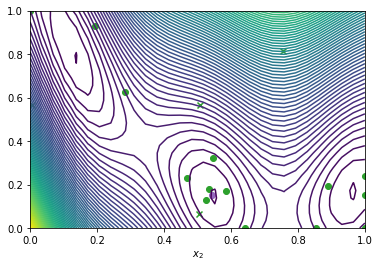

In [8]:
from util.plotting import plot_bo_points, plot_function_2d

_, ax = plot_function_2d(
    scaled_branin,
    search_space.lower,
    search_space.upper,
    grid_density=30,
    contour=True,
)
plot_bo_points(query_points, ax[0, 0], num_initial_points, arg_min_idx)
ax[0, 0].set_xlabel(r"$x_1$")
ax[0, 0].set_xlabel(r"$x_2$")

... or as a three-dimensional plot

In [9]:
from util.plotting_plotly import add_bo_points_plotly

fig = plot_function_plotly(
    scaled_branin, search_space.lower, search_space.upper, grid_density=20
)
fig.update_layout(height=500, width=500)

fig = add_bo_points_plotly(
    x=query_points[:, 0],
    y=query_points[:, 1],
    z=observations[:, 0],
    num_init=num_initial_points,
    idx_best=arg_min_idx,
    fig=fig,
)
fig.show()

We can also visualise the how each successive point compares the current best.

We produce two plots. The left hand plot shows the observations (crosses and dots), the current best (orange line), and the start of the optimization loop (blue line). The right hand plot is the same as the previous two-dimensional contour plot, but without the resulting observations. The best point is shown in each (purple dot).

Text(0.5, 0, '# evaluations')

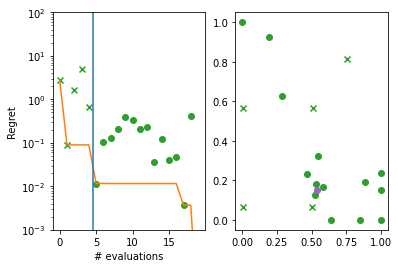

In [10]:
import matplotlib.pyplot as plt
from util.plotting import plot_regret

suboptimality = observations - SCALED_BRANIN_MINIMUM.numpy()
_, ax = plt.subplots(1, 2)
plot_regret(
    suboptimality, ax[0], num_init=num_initial_points, idx_best=arg_min_idx
)
plot_bo_points(
    query_points, ax[1], num_init=num_initial_points, idx_best=arg_min_idx
)

ax[0].set_yscale("log")
ax[0].set_ylabel("Regret")
ax[0].set_ylim(0.001, 100)
ax[0].set_xlabel("# evaluations")

We can visualise the model over the objective function by plotting the mean and 95% confidence intervals of its predictive distribution. Like with the data before, we can get the model with `.try_get_final_model()`.

In [11]:
from util.plotting_plotly import plot_model_predictions_plotly

fig = plot_model_predictions_plotly(
    result.try_get_final_model(),
    search_space.lower,
    search_space.upper,
)

fig = add_bo_points_plotly(
    x=query_points[:, 0],
    y=query_points[:, 1],
    z=observations[:, 0],
    num_init=num_initial_points,
    idx_best=arg_min_idx,
    fig=fig,
    figrow=1,
    figcol=1,
)
fig.show()

We can also inspect the model hyperparameters, and use the history to see how the length scales evolved over iterations. Note the history is saved at the *start* of each step, and as such never includes the final result, so we'll add that ourselves.

╒═════════════════════════╤══════════════════╤══════════════════╤═══════════╤═════════════╤═══════════╤═════════╤═════════════════════════════╕
│ name                    │ class            │ transform        │ prior     │ trainable   │ shape     │ dtype   │ value                       │
╞═════════════════════════╪══════════════════╪══════════════════╪═══════════╪═════════════╪═══════════╪═════════╪═════════════════════════════╡
│ GPR.mean_function.c     │ Parameter        │ Identity         │           │ True        │ ()        │ float64 │ 1.4175036499835085          │
├─────────────────────────┼──────────────────┼──────────────────┼───────────┼─────────────┼───────────┼─────────┼─────────────────────────────┤
│ GPR.kernel.variance     │ Parameter        │ Softplus         │ LogNormal │ True        │ ()        │ float64 │ 3.551603506820723           │
├─────────────────────────┼──────────────────┼──────────────────┼───────────┼─────────────┼───────────┼─────────┼───────────────────────

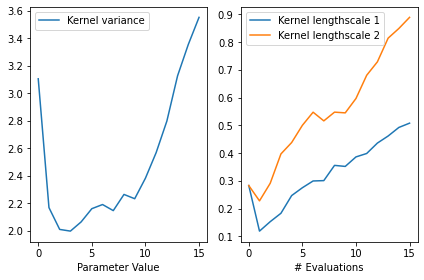

In [12]:
gpflow.utilities.print_summary(
    result.try_get_final_model().model  # type: ignore
)

variance_list = [
    step.model.model.kernel.variance.numpy()  # type: ignore
    for step in result.history + [result.final_result.unwrap()]
]

ls_list = [
    step.model.model.kernel.lengthscales.numpy()  # type: ignore
    for step in result.history + [result.final_result.unwrap()]
]

variance = np.array(variance_list)
ls = np.array(ls_list)

fig, ax = plt.subplots(1, 2)
ax[0].plot(variance, label="Kernel variance")
ax[0].legend(loc="upper left")
ax[0].set_xlabel("# Evaluations")
ax[0].set_xlabel("Parameter Value")

ax[1].plot(ls[:, 0], label="Kernel lengthscale 1")
ax[1].plot(ls[:, 1], label="Kernel lengthscale 2")
ax[1].legend(loc="upper left")
ax[1].set_xlabel("# Evaluations")

fig.tight_layout()

## Run the optimizer for more steps

If we need more iterations for better convergence, we can run the optimizer again using the data produced from the last run, as well as the model. We'll visualise the final data.

Optimization completed without errors


Text(0.5, 0, '$x_2$')

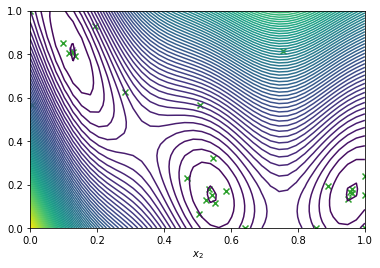

In [13]:
num_steps = 10
result = bo.optimize(
    num_steps, result.try_get_final_dataset(), result.try_get_final_model()
)
dataset = result.try_get_final_dataset()

arg_min_idx = tf.squeeze(tf.argmin(dataset.observations, axis=0))
_, ax = plot_function_2d(
    scaled_branin,
    search_space.lower,
    search_space.upper,
    grid_density=40,
    contour=True,
)

plot_bo_points(
    dataset.query_points.numpy(),
    ax=ax[0, 0],
    num_init=len(dataset.query_points),
    idx_best=arg_min_idx,
)

ax[0, 0].set_xlabel(r"$x_1$")
ax[0, 0].set_xlabel(r"$x_2$")

## LICENSE

[Apache License 2.0](https://github.com/secondmind-labs/trieste/blob/develop/LICENSE)